In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
import re
# Set seed for reproducibility
np.random.seed(5)
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spsk9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv("IMDB Data.csv")

In [3]:
df.head()

,Name,Synopsis,Genre
0,The Shawshank Redemption,Two imprisoned men bond over a number of years...,Drama
1,The Godfather,The aging patriarch of an organized crime dyna...,"Crime, Drama"
2,The Dark Knight,When the menace known as the Joker wreaks havo...,"Action, Crime, Drama"
3,The Godfather: Part II,The early life and career of Vito Corleone in ...,"Crime, Drama"
4,The Lord of the Rings: The Return of the King,Gandalf and Aragorn lead the World of Men agai...,"Adventure, Drama, Fantasy"


In [4]:
df.shape

(1000, 3)

In [24]:
data = df['Synopsis']

In [25]:
sent_tokenized = [sent for sent in nltk.sent_tokenize("""
                        Today (May 19, 2016) is his only daughter's wedding.
                        Vito Corleone is the Godfather.
                        """)]

# Word Tokenize first sentence from sent_tokenized, save as words_tokenized
words_tokenized = [word for word in nltk.word_tokenize(sent_tokenized[0])]

# Remove tokens that do not contain any letters from words_tokenized
import re

filtered = [word for word in words_tokenized if re.search('[a-zA-Z]', word)]

# Display filtered words to observe words after tokenization
filtered

['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

In [26]:
# Import the SnowballStemmer to perform stemming
from nltk.stem.snowball import SnowballStemmer

# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")

# Print filtered to observe words without stemming
print("Without stemming: ", filtered)

# Stem the words from filtered and store in stemmed_words
stemmed_words = [stemmer.stem(word) for word in filtered]

# Print the stemmed_words to observe words after stemming
print("After stemming:   ", stemmed_words)

Without stemming:  ['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']
After stemming:    ['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


In [27]:
# Define a function to perform both stemming and tokenization
def tokenize_and_stem(text):

    # Tokenize by sentence, then by word
    tokens = [y for x in nltk.sent_tokenize(text) for y in nltk.word_tokenize(x)]

    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]

    # Stem the filtered_tokens
    stems = [stemmer.stem(word) for word in filtered_tokens]

    return stems

words_stemmed = tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding.")
print(words_stemmed)

['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


In [31]:
# Import TfidfVectorizer to create TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))

In [32]:
tfidf_matrix =  tfidf_vectorizer.fit_transform([x for x in df["Synopsis"]])

print(tfidf_matrix.shape)

(1000, 3)


In [34]:
# Import k-means to perform clusters
from sklearn.cluster import KMeans

# Create a KMeans object with 5 clusters and save as km
km = KMeans(n_clusters=5)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
df["cluster"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
df['cluster'].value_counts()

0    641
1    160
2     90
3     73
4     36
Name: cluster, dtype: int64

In [39]:
df.head()

,Name,Synopsis,Genre,cluster
0,The Shawshank Redemption,Two imprisoned men bond over a number of years...,Drama,0
1,The Godfather,The aging patriarch of an organized crime dyna...,"Crime, Drama",0
2,The Dark Knight,When the menace known as the Joker wreaks havo...,"Action, Crime, Drama",0
3,The Godfather: Part II,The early life and career of Vito Corleone in ...,"Crime, Drama",0
4,The Lord of the Rings: The Return of the King,Gandalf and Aragorn lead the World of Men agai...,"Adventure, Drama, Fantasy",1


In [43]:
from sklearn.cluster import DBSCAN


DBS = DBSCAN().fit(tfidf_matrix)

dbs_cluster = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
df["dbs_cluster"] = dbs_cluster
# Display number of films per cluster (clusters from 0 to 4)
df['dbs_cluster'].value_counts()

df.head()

,Name,Synopsis,Genre,cluster,dbs_cluster
0,The Shawshank Redemption,Two imprisoned men bond over a number of years...,Drama,0,0
1,The Godfather,The aging patriarch of an organized crime dyna...,"Crime, Drama",0,0
2,The Dark Knight,When the menace known as the Joker wreaks havo...,"Action, Crime, Drama",0,0
3,The Godfather: Part II,The early life and career of Vito Corleone in ...,"Crime, Drama",0,0
4,The Lord of the Rings: The Return of the King,Gandalf and Aragorn lead the World of Men agai...,"Adventure, Drama, Fantasy",1,1


In [35]:
# Import cosine_similarity to calculate similarity of movie plots
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

In [37]:
# Import matplotlib.pyplot for plotting graphs
# Configure matplotlib to display the output inline
%matplotlib inline

# Import modules necessary to plot dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

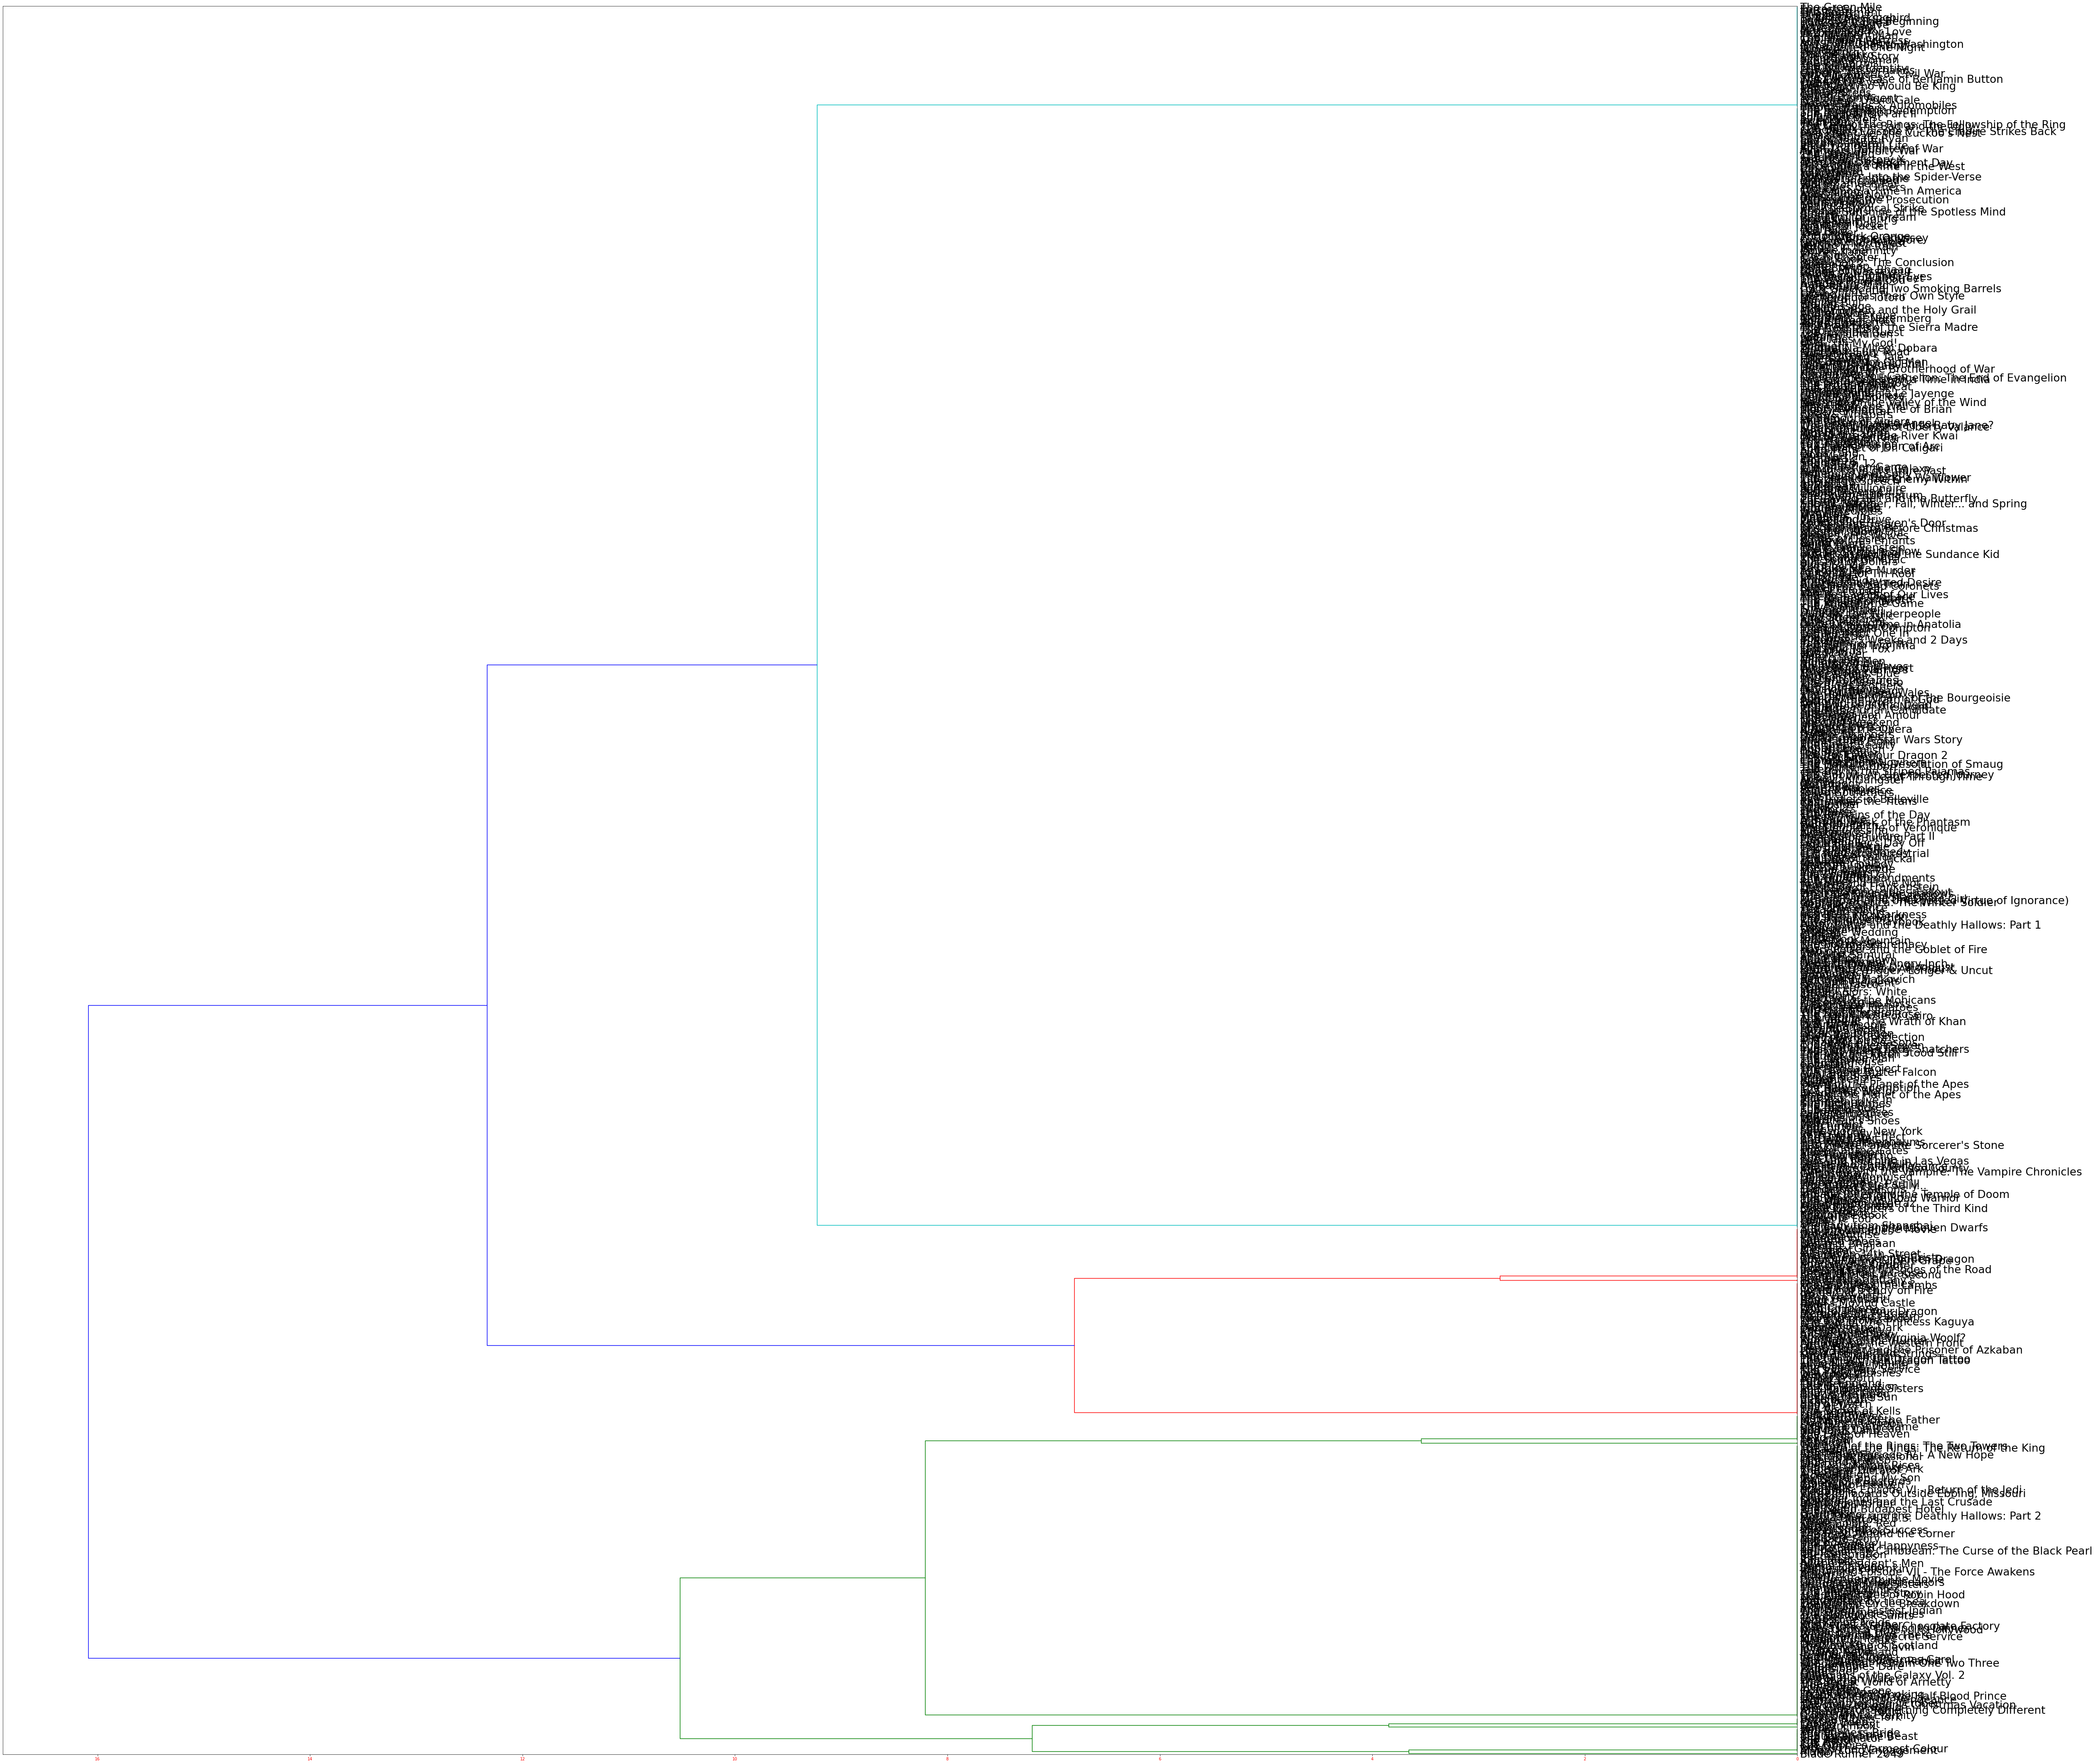

In [38]:
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings, orientation="left",
               labels=[x for x in df["Name"]],
               #leaf_rotation=90,
               leaf_font_size=27,)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(80, 80)

# Show the plotted dendrogram
plt.show()